In [1]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from torchvision import transforms,datasets

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 184519331.46it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 116253065.09it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 95323235.70it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5342268.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

Training data: 50000 Validation data: 10000 Test data:  10000


In [5]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

##Attack

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [7]:
model = Net().to(device)

In [8]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [9]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    # print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    print("Epoch: {} \t Training Loss: {} \t Validation Loss: {}".format(epoch+1,np.round((loss_per_epoch/len(train_loader)),10),np.round((val_loss_per_epoch/len(val_loader)),10)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

In [10]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...
Epoch: 1 	 Training Loss: 0.2811478691 	 Validation Loss: 0.1309098822
Epoch: 2 	 Training Loss: 0.1065333678 	 Validation Loss: 0.1124836958
Epoch: 3 	 Training Loss: 0.084079262 	 Validation Loss: 0.1042245587
Epoch: 4 	 Training Loss: 0.0754050665 	 Validation Loss: 0.1037963742
Epoch: 5 	 Training Loss: 0.0719437389 	 Validation Loss: 0.0912789067
Epoch: 6 	 Training Loss: 0.0672056454 	 Validation Loss: 0.084101321
Epoch: 7 	 Training Loss: 0.0642630268 	 Validation Loss: 0.0849549629
Epoch: 8 	 Training Loss: 0.0599600748 	 Validation Loss: 0.093067184
Epoch: 9 	 Training Loss: 0.0584411838 	 Validation Loss: 0.0860162231
Epoch: 10 	 Training Loss: 0.0565517406 	 Validation Loss: 0.0869853846


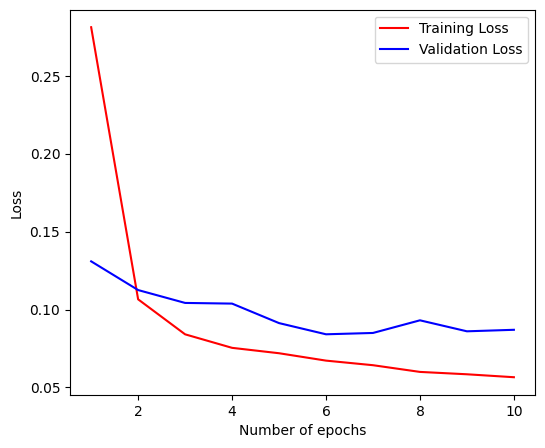

In [11]:
fig = plt.figure(figsize=(6,5))
plt.plot(np.arange(1,11), loss, "r-",label="Training Loss")
plt.plot(np.arange(1,11), val_loss,"b-",label="Validation Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Defining Non-Targeted FGSM:

In [12]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

In [13]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
          continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data

      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      else:
        pass

      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
          correct += 1
          if (epsilon == 0) and (len(adv_examples) < 5):
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
      else:
          if len(adv_examples) < 5:
              adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {} \t Test Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc, adv_examples

Epsilon: 0 	 Test Accuracy = 9708 / 10000 = 0.9708
Epsilon: 0.007 	 Test Accuracy = 9668 / 10000 = 0.9668
Epsilon: 0.01 	 Test Accuracy = 9688 / 10000 = 0.9688
Epsilon: 0.02 	 Test Accuracy = 9619 / 10000 = 0.9619
Epsilon: 0.03 	 Test Accuracy = 9554 / 10000 = 0.9554
Epsilon: 0.05 	 Test Accuracy = 9384 / 10000 = 0.9384
Epsilon: 0.1 	 Test Accuracy = 8705 / 10000 = 0.8705
Epsilon: 0.2 	 Test Accuracy = 5863 / 10000 = 0.5863
Epsilon: 0.3 	 Test Accuracy = 3034 / 10000 = 0.3034


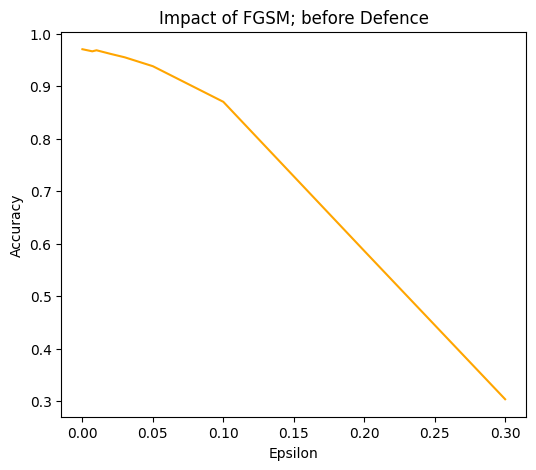

In [14]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
accuracies = []
examples = []
attack = "fgsm"
for eps in epsilons:
      acc, ex = test(model, device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
plt.figure(figsize=(6,5))
plt.plot(epsilons, accuracies, "-", color='orange')
plt.title("Impact of FGSM; before Defence")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

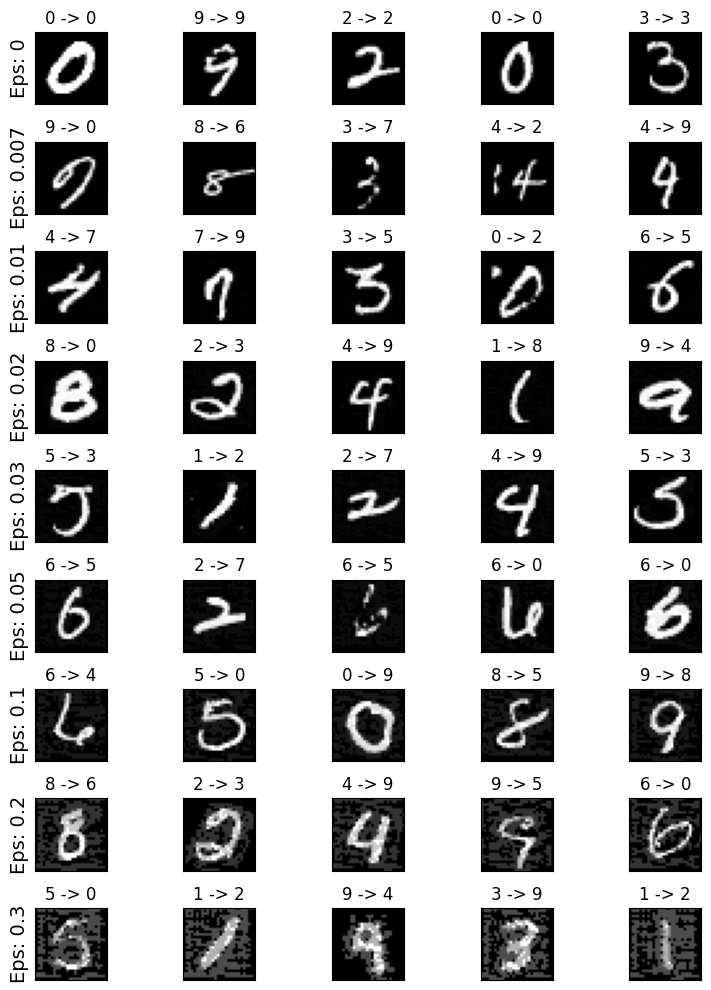

In [15]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# Defensive Distillation
## NetF is Teacher Network while NetF1 is Student Model

In [16]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [18]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label  = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} \t Training Loss: {} \t Validation Loss: {}".format(epoch+1,np.round((loss_per_epoch/len(train_loader)),10),np.round((val_loss_per_epoch/len(val_loader)),10)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

def test(model,device,test_loader,epsilon,Temp,attack):
  correct=0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    output = F.log_softmax(output/Temp,dim=1)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
        continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    else:
      pass

    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
        if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

  return final_acc,adv_examples

In [19]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  #converting target labels to soft labels
  for data in train_loader:
    input, label  = data[0].to(device),data[1].to(device)
    softlabel  = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(6,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  accuracies = []
  examples = []
  for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,1,"fgsm")
      accuracies.append(acc)
      examples.append(ex)

  plt.figure(figsize=(6,5))
  plt.plot(epsilons, accuracies, "*-")
  # plt.title(attack)
  plt.title("Impact of FGSM; after Defence")
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
      for j in range(len(examples[i])):
          cnt += 1
          plt.subplot(len(epsilons),len(examples[0]),cnt)
          plt.xticks([], [])
          plt.yticks([], [])
          if j == 0:
              plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
          orig,adv,ex = examples[i][j]
          plt.title("{} -> {}".format(orig, adv))
          plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Fitting the model...
Epoch: 1 	 Training Loss: 0.5563110999 	 Validation Loss: 0.3933087167
Epoch: 2 	 Training Loss: 0.340260575 	 Validation Loss: 0.3039287015
Epoch: 3 	 Training Loss: 0.2631432786 	 Validation Loss: 0.2440481443
Epoch: 4 	 Training Loss: 0.2047757999 	 Validation Loss: 0.200597333
Epoch: 5 	 Training Loss: 0.168607711 	 Validation Loss: 0.1657701135
Epoch: 6 	 Training Loss: 0.1437052133 	 Validation Loss: 0.1438932647
Epoch: 7 	 Training Loss: 0.1278608893 	 Validation Loss: 0.1310475915
Epoch: 8 	 Training Loss: 0.113805411 	 Validation Loss: 0.1279736792
Epoch: 9 	 Training Loss: 0.1080610693 	 Validation Loss: 0.1197267812
Epoch: 10 	 Training Loss: 0.1015821191 	 Validation Loss: 0.1225776271


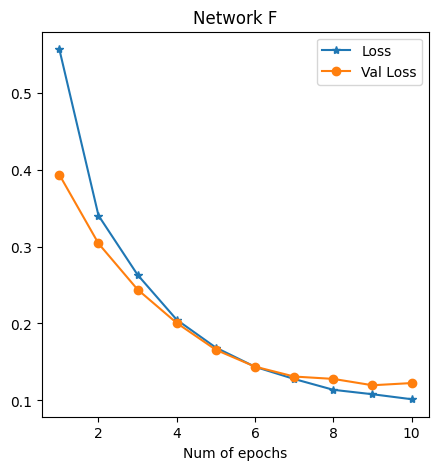

Fitting the model...
Epoch: 1 	 Training Loss: 0.697784003 	 Validation Loss: 0.5088195365
Epoch: 2 	 Training Loss: 0.4653333277 	 Validation Loss: 0.4365343587
Epoch: 3 	 Training Loss: 0.4141535134 	 Validation Loss: 0.4177435323
Epoch: 4 	 Training Loss: 0.3640250109 	 Validation Loss: 0.3515230271
Epoch: 5 	 Training Loss: 0.3079653765 	 Validation Loss: 0.3014966391
Epoch: 6 	 Training Loss: 0.2682540082 	 Validation Loss: 0.2702189698
Epoch: 7 	 Training Loss: 0.2386586749 	 Validation Loss: 0.243728695
Epoch: 8 	 Training Loss: 0.2160150083 	 Validation Loss: 0.2206049678
Epoch: 9 	 Training Loss: 0.2013246345 	 Validation Loss: 0.220037734
Epoch: 10 	 Training Loss: 0.1852063909 	 Validation Loss: 0.1999504686


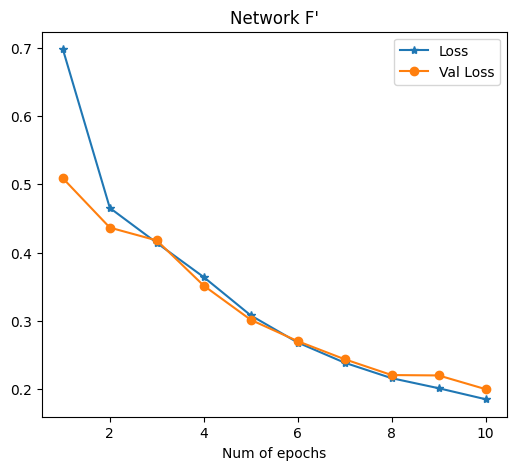

Epsilon: 0	Test Accuracy = 9173 / 10000 = 0.9173
Epsilon: 0.007	Test Accuracy = 9218 / 10000 = 0.9218
Epsilon: 0.01	Test Accuracy = 9178 / 10000 = 0.9178
Epsilon: 0.02	Test Accuracy = 9164 / 10000 = 0.9164
Epsilon: 0.03	Test Accuracy = 9151 / 10000 = 0.9151
Epsilon: 0.05	Test Accuracy = 9099 / 10000 = 0.9099
Epsilon: 0.1	Test Accuracy = 9123 / 10000 = 0.9123
Epsilon: 0.2	Test Accuracy = 9004 / 10000 = 0.9004
Epsilon: 0.3	Test Accuracy = 8966 / 10000 = 0.8966


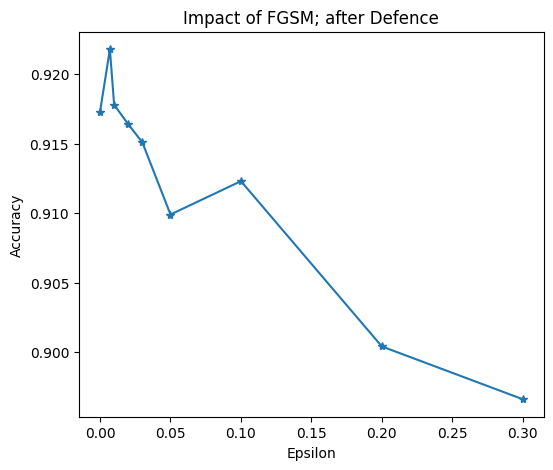

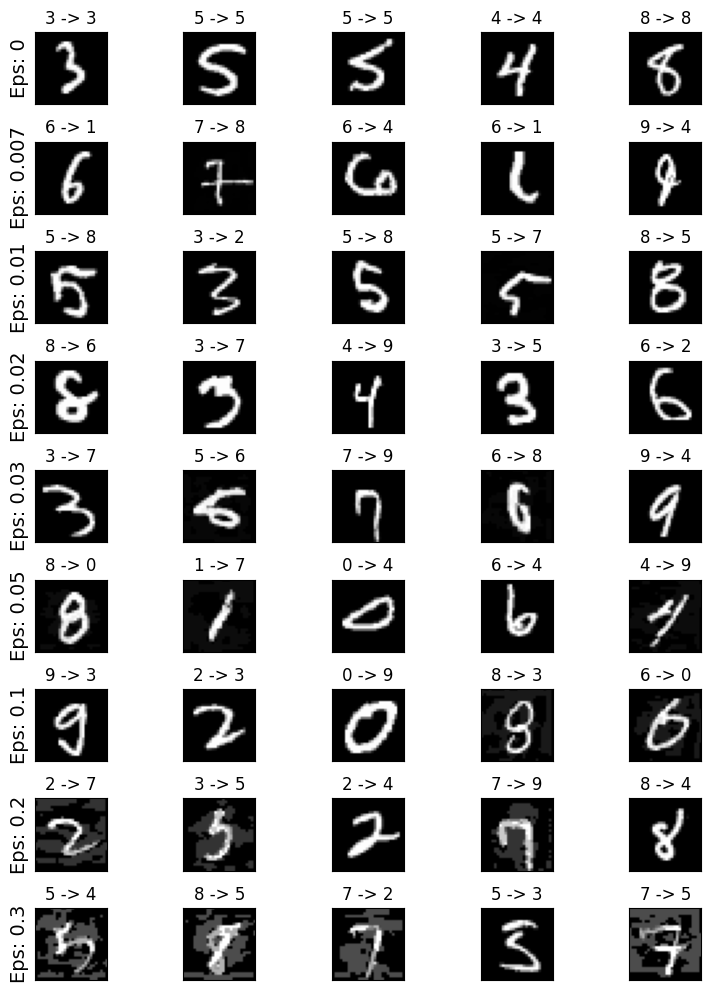

In [21]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)